In [1]:
!pip install tensorflow_decision_forests -U --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 35.5 MB/s eta 0:00:00


In [2]:
!pip install wurlitzer -U --quiet

In [3]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import matplotlib.pyplot as plt

In [4]:
def make_dataset(num_examples, num_features, seed=1234):
  np.random.seed(seed)
  features = np.random.uniform(-1, 1, size=(num_examples, num_features))
  noise = np.random.uniform(size=(num_examples))

  left_side = np.sqrt(
      np.sum(np.multiply(np.square(features[:, 0:2]), [1, 2]), axis=1))
  right_side = features[:, 2] * 0.7 + np.sin(
      features[:, 3] * 10) * 0.5 + noise * 0.0 + 0.5

  labels = left_side <= right_side
  return features, labels.astype(int)

In [6]:
make_dataset(num_examples=5, num_features=4)

(array([[-0.6169611 ,  0.24421754, -0.12454452,  0.57071717],
        [ 0.55995162, -0.45481479, -0.44707149,  0.60374436],
        [ 0.91627871,  0.75186527, -0.28436546,  0.00199025],
        [ 0.36692587,  0.42540405, -0.25949849,  0.12239237],
        [ 0.00616633, -0.9724631 ,  0.54565324,  0.76528238]]),
 array([0, 0, 0, 1, 0]))

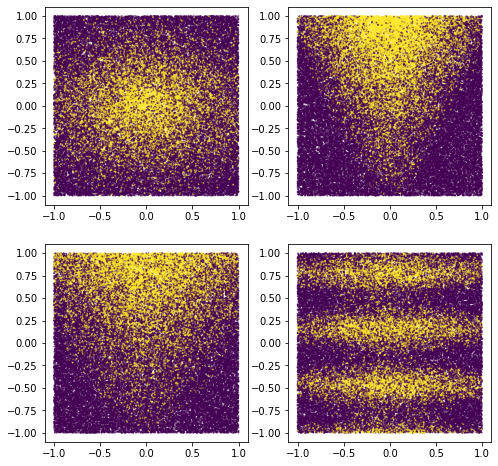

In [8]:
plot_features, plot_label = make_dataset(num_examples=50000, num_features=4)

plt.rcParams["figure.figsize"] = [8, 8]
common_args = dict(c=plot_label, s=1.0, alpha=0.5)

plt.subplot(2, 2, 1)
plt.scatter(plot_features[:, 0], plot_features[:, 1], **common_args)

plt.subplot(2, 2, 2)
plt.scatter(plot_features[:, 1], plot_features[:, 2], **common_args)

plt.subplot(2, 2, 3)
plt.scatter(plot_features[:, 0], plot_features[:, 2], **common_args)

plt.subplot(2, 2, 4)
plt.scatter(plot_features[:, 0], plot_features[:, 3], **common_args)

In [9]:
def make_tf_dataset(batch_size=64, **args):
  features, labels = make_dataset(**args)
  return tf.data.Dataset.from_tensor_slices(
      (features, labels)).batch(batch_size)


num_features = 10

train_dataset = make_tf_dataset(
    num_examples=2500, num_features=num_features, batch_size=100, seed=1234)
test_dataset = make_tf_dataset(
    num_examples=10000, num_features=num_features, batch_size=100, seed=5678)

In [10]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [11]:
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [12]:
# Input features.
raw_features = tf.keras.layers.Input(shape=(num_features,))

# Stage 1
# =======

# Common learnable pre-processing
preprocessor = tf.keras.layers.Dense(10, activation=tf.nn.relu6)
preprocess_features = preprocessor(raw_features)

# Stage 2
# =======

# Model #1: NN
m1_z1 = tf.keras.layers.Dense(5, activation=tf.nn.relu6)(preprocess_features)
m1_pred = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(m1_z1)

# Model #2: NN
m2_z1 = tf.keras.layers.Dense(5, activation=tf.nn.relu6)(preprocess_features)
m2_pred = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(m2_z1)


# Model #3: DF
model_3 = tfdf.keras.RandomForestModel(num_trees=1000, random_seed=1234)
m3_pred = model_3(preprocess_features)

# Model #4: DF
model_4 = tfdf.keras.RandomForestModel(
    num_trees=1000,
    #split_axis="SPARSE_OBLIQUE", # Uncomment this line to increase the quality of this model
    random_seed=4567)
m4_pred = model_4(preprocess_features)

# Since TF-DF uses deterministic learning algorithms, you should set the model's
# training seed to different values otherwise both
# `tfdf.keras.RandomForestModel` will be exactly the same.

# Stage 3
# =======

mean_nn_only = tf.reduce_mean(tf.stack([m1_pred, m2_pred], axis=0), axis=0)
mean_nn_and_df = tf.reduce_mean(
    tf.stack([m1_pred, m2_pred, m3_pred, m4_pred], axis=0), axis=0)

# Keras Models
# ============

ensemble_nn_only = tf.keras.models.Model(raw_features, mean_nn_only)
ensemble_nn_and_df = tf.keras.models.Model(raw_features, mean_nn_and_df)

Use /tmp/tmp4xxo482v as temporary training directory


Use /tmp/tmpcn0c01lo as temporary training directory


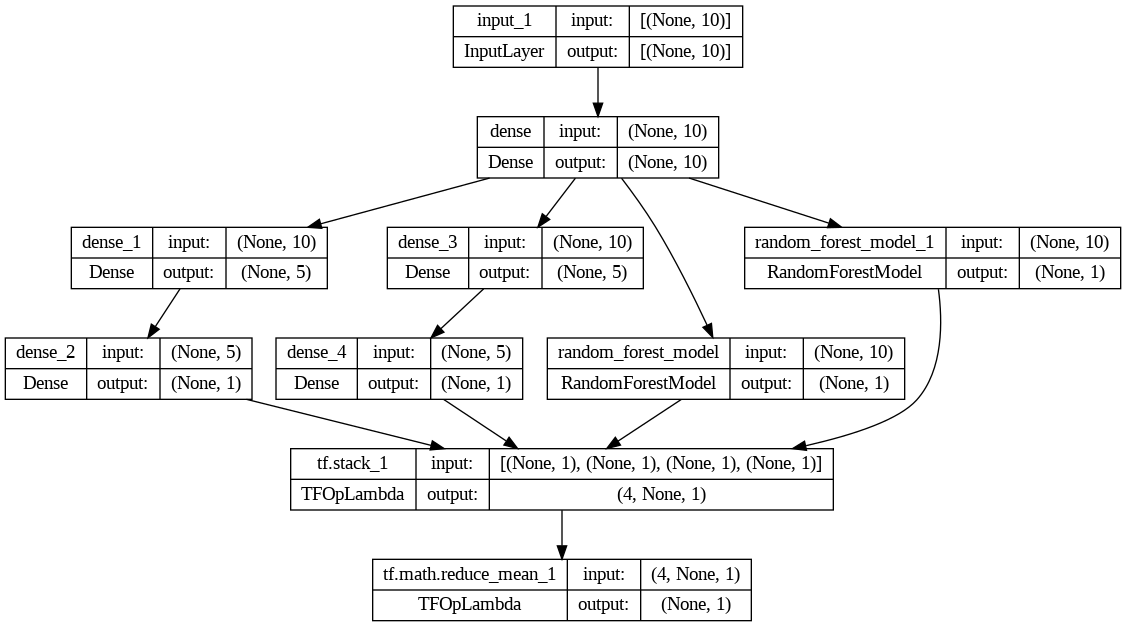

In [13]:
from keras.utils.vis_utils import plot_model

plot_model(ensemble_nn_and_df, to_file="/tmp/model.png", show_shapes=True)

In [14]:
%%time
ensemble_nn_only.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"])

ensemble_nn_only.fit(train_dataset, epochs=2, validation_data=test_dataset)

Epoch 1/2
25/25 [==============================] - 6s 66ms/step - loss: 0.8086 - accuracy: 0.2728 - val_loss: 0.7680 - val_accuracy: 0.3282
Epoch 2/2
25/25 [==============================] - 0s 18ms/step - loss: 0.7393 - accuracy: 0.4148 - val_loss: 0.7099 - val_accuracy: 0.4990
CPU times: user 3.01 s, sys: 82.3 ms, total: 3.09 s
Wall time: 7.67 s


In [15]:
evaluation_nn_only = ensemble_nn_only.evaluate(test_dataset, return_dict=True)
print("Accuracy (NN #1 and #2 only): ", evaluation_nn_only["accuracy"])
print("Loss (NN #1 and #2 only): ", evaluation_nn_only["loss"])

100/100 [==============================] - 1s 5ms/step - loss: 0.7099 - accuracy: 0.4990
Accuracy (NN #1 and #2 only):  0.49900001287460327
Loss (NN #1 and #2 only):  0.7099039554595947


In [16]:
%%time
train_dataset_with_preprocessing = train_dataset.map(lambda x,y: (preprocessor(x), y))
test_dataset_with_preprocessing = test_dataset.map(lambda x,y: (preprocessor(x), y))

model_3.fit(train_dataset_with_preprocessing)
model_4.fit(train_dataset_with_preprocessing)

Cause: could not parse the source code of <function <lambda> at 0x7febe478f0d0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7febe478f0d0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7febe8eb1790>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7febe8eb1790>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Reading training dataset...


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:08.174050. Found 2500 examples.
Training model...
Model trained in 0:00:07.872060
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.232976. Found 2500 examples.
Training model...
Model trained in 0:00:12.204164
Compiling model...
Model compiled.
CPU times: user 31 s, sys: 1.58 s, total: 32.5 s
Wall time: 38.5 s


In [17]:
model_3.compile(["accuracy"])
model_4.compile(["accuracy"])

evaluation_df3_only = model_3.evaluate(
    test_dataset_with_preprocessing, return_dict=True)
evaluation_df4_only = model_4.evaluate(
    test_dataset_with_preprocessing, return_dict=True)

print("Accuracy (DF #3 only): ", evaluation_df3_only["accuracy"])
print("Accuracy (DF #4 only): ", evaluation_df4_only["accuracy"])

100/100 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - accuracy: 0.7537
Accuracy (DF #3 only):  0.7538999915122986
Accuracy (DF #4 only):  0.7537000179290771


In [18]:
ensemble_nn_and_df.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

evaluation_nn_and_df = ensemble_nn_and_df.evaluate(
    test_dataset, return_dict=True)

print("Accuracy (2xNN and 2xDF): ", evaluation_nn_and_df["accuracy"])
print("Loss (2xNN and 2xDF): ", evaluation_nn_and_df["loss"])

100/100 [==============================] - 4s 32ms/step - loss: 0.5579 - accuracy: 0.7522
Accuracy (2xNN and 2xDF):  0.7522000074386597
Loss (2xNN and 2xDF):  0.5579411387443542
